In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/MSDS/Winter2021/521 - DataAnalysis/Term Project/Data

/content/gdrive/MyDrive/MSDS/Winter2021/521 - DataAnalysis/Term Project/Data


In [3]:
# Import Packages
import pandas as pd

In [4]:
# Read contract data
contractDf = pd.read_excel('./ContractData.xls')  # Import contract data file
print(contractDf.shape)
Crelevantfields = ['player_id','first_name','last_name','position','cap_hit','total_salary','signing_date','length','contract_end'] # identify needed fields
contractDf = contractDf[Crelevantfields] # select needed fields
contractDf.head()

(7656, 27)


,player_id,first_name,last_name,position,cap_hit,total_salary,signing_date,length,contract_end
0,2510,Patrick,Kane,Right Wing,10500000,13800000.0,2014-07-09,8,2022-2023
1,2516,Jonathan,Toews,Center,10500000,13800000.0,2014-07-09,8,2022-2023
2,2039,Anze,Kopitar,Center,10000000,13000000.0,2016-01-16,8,2023-2024
3,1216,Alex,Ovechkin,Left Wing,9538462,10000000.0,2008-01-10,13,2020-2021
4,1777,Evgeni,Malkin,Center,9500000,9500000.0,2013-06-13,8,2021-2022


In [5]:
# Read performance data
performanceDf = pd.read_excel('./PerformanceData.xlsx') # import performance file
print(contractDf.shape)
Prelevantfields = ['player_id','season_name','team_id_source','games_played','toi','gf_percentage','xgf_percentage','cf_percentage','g60','p60'] # identify relevant fields
performanceDf = performanceDf[Prelevantfields] # select relevant fields
performanceDf.head()

(7656, 9)


,player_id,season_name,team_id_source,games_played,toi,gf_percentage,xgf_percentage,cf_percentage,g60,p60
0,1288,2019-2020,ANA,69,966.983333,44.3,50.7,49.1,0.558438,1.551216
1,1556,2019-2020,ANA,6,53.616667,57.1,44.2,49.0,NaN,2.238110
2,4234,2019-2020,ANA,46,653.250000,46.2,43.1,43.0,0.091848,0.275545
3,3392,2019-2020,ANA,49,751.166667,54.8,46.0,47.4,0.159751,1.038385
4,3037,2019-2020,ANA,71,901.550000,50.0,50.1,51.6,1.197937,1.996561


In [6]:
# Merge datasets
df = contractDf.merge(performanceDf, on = 'player_id', how = 'left', indicator=True) # left join the data to combine contract + performance
print(df.shape)
df.head()

(7961, 19)


,player_id,first_name,last_name,position,cap_hit,total_salary,signing_date,length,contract_end,season_name,team_id_source,games_played,toi,gf_percentage,xgf_percentage,cf_percentage,g60,p60,_merge
0,2510,Patrick,Kane,Right Wing,10500000,13800000.0,2014-07-09,8,2022-2023,2019-2020,CHI,70.0,1139.300000,59.0,46.4,47.4,1.000614,2.685860,both
1,2516,Jonathan,Toews,Center,10500000,13800000.0,2014-07-09,8,2022-2023,2019-2020,CHI,70.0,937.383333,50.5,47.7,49.5,0.704088,2.624327,both
2,2039,Anze,Kopitar,Center,10000000,13000000.0,2016-01-16,8,2023-2024,2019-2020,LAK,70.0,1050.016667,55.6,50.4,52.1,0.685703,1.714259,both
3,1216,Alex,Ovechkin,Left Wing,9538462,10000000.0,2008-01-10,13,2020-2021,2019-2020,WSH,66.0,980.100000,47.5,49.6,51.4,1.652893,2.265075,both
4,1777,Evgeni,Malkin,Center,9500000,9500000.0,2013-06-13,8,2021-2022,2019-2020,PIT,55.0,796.466667,57.0,55.7,53.2,1.205324,3.465305,both


In [7]:
# Check merge results

print(df['_merge'].value_counts())
training = df.loc[(df['_merge'] == 'both') & (df['position'] != 'Goaltender')] # filter data set for where join matched and player is not a goalie
training['total_contract_value'] = training['cap_hit'] * training['length'] # calculate target y variable

training[[	'games_played',	'toi',	'gf_percentage',	'xgf_percentage',	'g60',	'p60', 'total_contract_value' ]]


both          4568
left_only     3393
right_only       0
Name: _merge, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,games_played,toi,gf_percentage,xgf_percentage,g60,p60,total_contract_value
0,70.0,1139.300000,59.0,46.4,1.000614,2.685860,84000000
1,70.0,937.383333,50.5,47.7,0.704088,2.624327,84000000
2,70.0,1050.016667,55.6,50.4,0.685703,1.714259,80000000
3,66.0,980.100000,47.5,49.6,1.652893,2.265075,124000006
4,55.0,796.466667,57.0,55.7,1.205324,3.465305,76000000
...,...,...,...,...,...,...,...
7956,71.0,1486.450000,48.8,51.3,0.242188,1.009116,64000000
7957,69.0,889.300000,48.5,49.2,0.944563,1.821657,57200000
7958,71.0,997.250000,57.7,49.7,0.842316,1.865129,52000000
7959,65.0,1231.800000,48.5,42.4,0.194837,0.681929,50000000


In [ ]:
#######################
### Begin Modelling ###
#######################

In [8]:
# Import Packages

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.preprocessing import StandardScaler

y_value = training['total_contract_value'] # identify target variable

x_values = training[[	'games_played',	'toi',	'gf_percentage',	'xgf_percentage',	'g60',	'p60' ]] # identify independent variables
x_values = x_values.fillna(0.0) # fill NaN values in independent fields with 0 since these metrics are continuous values


x_train, x_test, y_train, y_test = train_test_split(x_values, y_value, test_size=0.33, random_state=42) # split test and train sets

linreg_pipeline = Pipeline([
                  ('std', StandardScaler()),            # standardize values
                  ('pca', PCA(n_components=.95)),       # feature engineer with PCA
                  ('lin', LinearRegression())           # apply model
                  ])

knn_pipeline = Pipeline([
                  ('std', StandardScaler()),
                  ('pca', PCA(n_components=.95)),
                  ('knn', KNeighborsRegressor(10))
                  ])

dtree_pipeline = Pipeline([
                  ('std', StandardScaler()),
                  ('pca', PCA(n_components=.95)),
                  ('dtree', DecisionTreeRegressor())
                  ])

rforest_pipeline = Pipeline([
                  ('std', StandardScaler()),
                  ('pca', PCA(n_components=.95)),
                  ('rfr', RandomForestRegressor())
                  ])


# Prepare model pipeline
pipelines = [linreg_pipeline, knn_pipeline, dtree_pipeline, rforest_pipeline]
model_names = ['Linear Regression', 'K Nearest Neighbors', 'Decision Tree', 'Random Forest']
count = 0

for p in pipelines:
    
    p.fit(x_train, y_train)
    predictions = p.predict(x_test)

#    print("For "+ name +", precision, recall, and F1 were:")
    print("")
    print(model_names[count])
    print("RMSE:", mean_squared_error(predictions, y_test, squared=False))
    print("R Square:", r2_score(predictions, y_test))
    print("MAE:", mean_absolute_error(predictions, y_test))
    print("")
    count += 1

x_values


Linear Regression
RMSE: 19666717.24438892
R Square: -2.703218608600456
MAE: 14249025.501041474


K Nearest Neighbors
RMSE: 15690239.345818887
R Square: 0.11223717547614176
MAE: 10783597.671618037


Decision Tree
RMSE: 8617592.357675409
R Square: 0.837804603258401
MAE: 4001146.0121350153


Random Forest
RMSE: 8687519.612943638
R Square: 0.8214547888648644
MAE: 4641186.804891639



,games_played,toi,gf_percentage,xgf_percentage,g60,p60
0,70.0,1139.300000,59.0,46.4,1.000614,2.685860
1,70.0,937.383333,50.5,47.7,0.704088,2.624327
2,70.0,1050.016667,55.6,50.4,0.685703,1.714259
3,66.0,980.100000,47.5,49.6,1.652893,2.265075
4,55.0,796.466667,57.0,55.7,1.205324,3.465305
...,...,...,...,...,...,...
7956,71.0,1486.450000,48.8,51.3,0.242188,1.009116
7957,69.0,889.300000,48.5,49.2,0.944563,1.821657
7958,71.0,997.250000,57.7,49.7,0.842316,1.865129
7959,65.0,1231.800000,48.5,42.4,0.194837,0.681929


1. add Exploratory Data Analysis of predicted values
2. add Plots
3. try new parameters

In [21]:
# Import Current Season Data Set
RealWorld = pd.read_csv('./skaters.csv')

# Filter for all situations 
RealWorld = RealWorld.loc[ (RealWorld['situation'] == 'all') & (RealWorld['games_played'] > 10)]

# Select important fields
RWRelevantFields = ['playerId',	'name',	'games_played',	'icetime',	'OnIce_F_xGoals', 'OnIce_A_xGoals',	'I_F_points',	'I_F_goals',	'OnIce_F_goals',	'OnIce_A_goals']
rwdf = RealWorld[RWRelevantFields]

# Reset index
rwdf = rwdf.reset_index()

# Calculate fields
rwdf['toi'] = rwdf['icetime'] /  60                                                                             # convert seconds to mins
rwdf['g60'] = rwdf['I_F_goals'] / rwdf['toi'] * 60                                                          # calculate rate stats
rwdf['p60'] = rwdf['I_F_points'] / rwdf['toi'] * 60                                                         # calculate rate stats
rwdf['gf_percentage'] = (rwdf['OnIce_F_goals'] / ( rwdf['OnIce_F_goals'] + rwdf['OnIce_A_goals'] ) ) * 100      # calculate rate stats
rwdf['xgf_percentage'] = (rwdf['OnIce_F_xGoals'] / ( rwdf['OnIce_F_xGoals'] + rwdf['OnIce_A_xGoals'] ) ) * 100  # calculate rate stats

# Select & Rename fields
rwdf = rwdf[['name', 'games_played','toi','gf_percentage', 'xgf_percentage','g60','p60']]
rwdf.columns = ['name',	'games_played',	'toi',	'gf_percentage',	'xgf_percentage',	'g60',	'p60' ]


In [22]:
# Explore Model Performance & Predictions of Decision Tree
rwdf = rwdf.fillna(0.0)
dtreetrain = rwdf[[	 'games_played',	'toi',	'gf_percentage',	'xgf_percentage',	'g60',	'p60' ]]

dtree_pipeline = Pipeline([
                  ('std', StandardScaler()),
                  ('pca', PCA(n_components=.95)),
                  ('dtree', DecisionTreeRegressor())
                  ])

dtree_pipeline.fit(x_train, y_train)

predictions = dtree_pipeline.predict(dtreetrain)
rwdf['predictedcontractvalue'] = predictions
#rwdf.to_csv('./DecisionTreeResults.csv')
print(set(predictions))

{24000000.0, 16000000.0, 2016250.0, 11562500.25, 1763333.3333333333, 1450000.0, 2530835.0, 2452500.0, 1613333.3333333333, 7557142.857142857, 1535000.0, 2175000.0, 816666.6666666666, 1619999.3333333333, 1300000.0, 1940000.0, 2259999.0, 6583333.333333333, 2163750.0, 666666.6666666666, 18750000.0, 2659376.25, 1971250.0, 38312500.0, 33000000.0, 23400000.0, 1821249.5, 1000000.0, 4033092.0, 1483333.3333333333, 17000000.0, 2570824.6, 1966666.6666666667, 850000.0, 28170833.333333332, 1333333.3333333333, 2535000.0, 700000.0, 3900000.0, 5265000.0, 2149998.0, 8550000.0, 10150000.0, 16550000.0, 2512500.0, 1733749.5, 1275000.0, 2319999.0, 42000000.0, 104400000.0, 10000000.0, 2682501.0, 1366666.6666666667, 874125.0, 1850000.0, 1451666.6666666667, 5291666.666666667, 2333333.3333333335, 4175000.0, 2345625.0, 2183333.3333333335, 2424999.0, 2666666.6666666665, 1550000.0, 2274999.0, 2359998.0, 2141375.0, 27000000.0, 9400000.0, 1648333.3333333333, 1008333.3333333334, 1612500.0, 1733333.3333333333, 2705625

In [23]:
# Explore Model Performance & Predictions of Random Forest
rwdf = rwdf.fillna(0.0)
realworldresults = rwdf[[	 'games_played',	'toi',	'gf_percentage',	'xgf_percentage',	'g60',	'p60' ]]

rforest_pipeline = Pipeline([
                  ('std', StandardScaler()),
                  ('pca', PCA(n_components=.95)),
                  ('rfr', RandomForestRegressor())
                  ])

rforest_pipeline.fit(x_train, y_train)

predictions = rforest_pipeline.predict(realworldresults)
realworldresults['predicted_contract_value'] = predictions
realworldresults['player_name'] = rwdf['name']
#realworldresults.to_csv('./RandomForestResults.csv')
print(set(predictions))

{2467845.527038961, 1730574.9949920634, 4040720.421571429, 4726801.995809523, 1751058.1170238096, 4724754.208861111, 14522390.521468254, 12197918.206345238, 3289123.1565714288, 7036964.302523809, 4661283.384714286, 2250791.6486904756, 2500649.298845599, 3590188.692261904, 3192880.7266071434, 4730940.687999999, 2281535.228214286, 2234435.976111111, 11546692.220999999, 9752650.09809524, 3422283.6541865077, 4878411.057743589, 19482703.621396102, 19271762.444999997, 3965013.7962912084, 3305559.7850436512, 13738072.61727381, 5769306.389611112, 1568860.7745476188, 9001056.238714285, 8157282.133726189, 5664866.662440476, 27930725.872619048, 7913574.013095238, 5072998.442285714, 18030694.103041124, 2709609.1132857143, 3475563.861619047, 2726005.4399999995, 9613429.692380952, 3184763.8935714294, 4343934.445476191, 6817921.872261906, 2449545.8437499995, 2846866.485801587, 3037338.0771904755, 6865053.0721785715, 3801248.484404762, 4483234.978095237, 6508708.726880952, 9992359.392761905, 2121896.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# Explore Model Performance & Predictions of Linear Regression
rwdf = rwdf.fillna(0.0)
rwdf = rwdf[[	 'games_played',	'toi',	'gf_percentage',	'xgf_percentage',	'g60',	'p60' ]]

linreg_pipeline = Pipeline([
                  ('pca', PCA(n_components=6)),
                  ('lin', LinearRegression())
                  ])

linreg_pipeline.fit(x_train, y_train)
predictions = linreg_pipeline.predict(rwdf)
rwdf['predictedcontractvalue'] = predictions
#rwdf.to_csv('./LinearRegressionResults.csv')

Exploratory Analysis

In [13]:
y_pred_rf = rforest_pipeline.predict(x_test)

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
y_test_standard = (y_test - np.mean(y_test))/np.std(y_test)

No handles with labels found to put in legend.


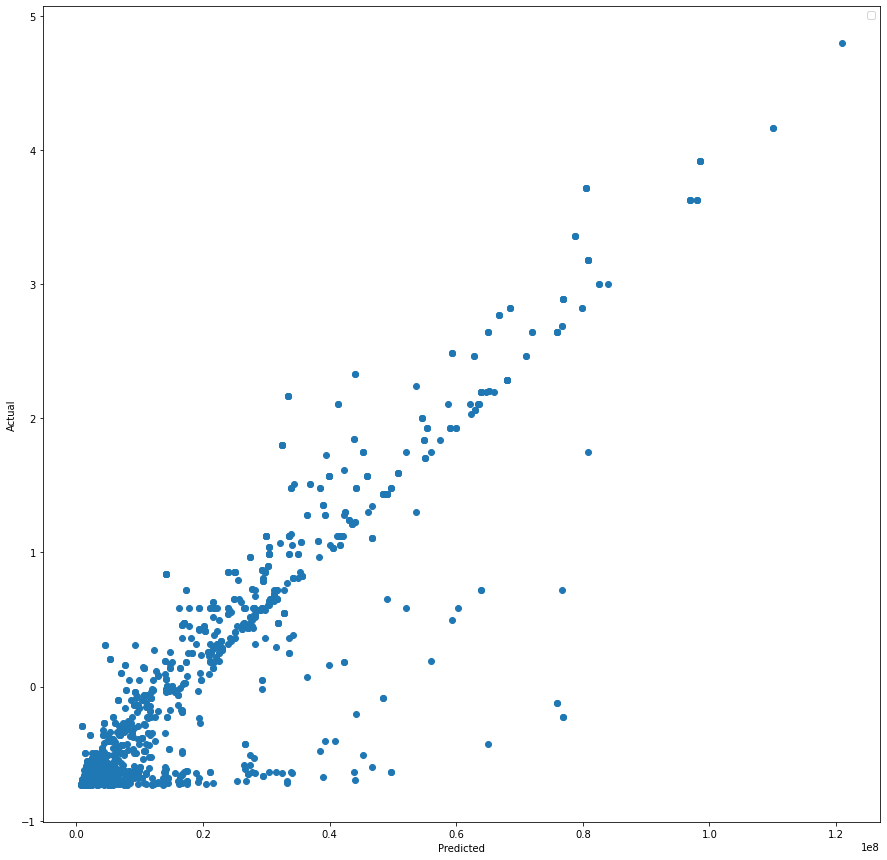

In [16]:
plt.figure(figsize=(15,15))
plt.scatter(y_pred_rf,y_test_standard,)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.legend()
plt.show()

In [17]:
d = {
    
    'predicted':y_pred_rf
}

In [18]:
df = pd.DataFrame(d)
df.head()

,predicted
0,1.736067e+06
1,1.628092e+07
2,3.955275e+06
3,1.437998e+06
4,1.948721e+06


<Figure size 1080x1080 with 0 Axes>

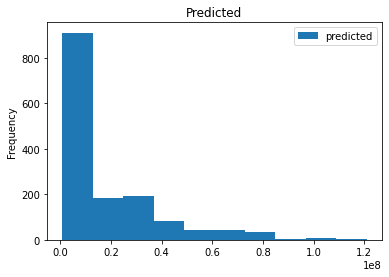

In [19]:
plt.figure(figsize=(15,15))
df.plot.hist()
plt.title("Predicted")
plt.show()